# Import

In [121]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import scipy

# Récupération signaux

In [185]:
def get_data_from_file(filepath, seq_len):
    data = scipy.io.loadmat(filepath)
    return data['voltage'][0][:seq_len].astype(np.float64), data['current'][0][:seq_len].astype(np.float64), data['f1'][0][:seq_len].astype(np.float64), data['f2'][0][:seq_len].astype(np.float64), data['f3'][0][:seq_len].astype(np.float64)


# Fonction pour normaliser les signaux
# Problèmes avec cette normalisation : Elle est local et non global sur l'ensemble des signaux
def normalize_data(list_data):

    normalize_data_list = []

    for data in list_data:
        norm = np.linalg.norm(data)
        data_normalized = data / norm
        normalize_data_list.append(data_normalized)
    
    return normalize_data_list


def generate_data(dossier, seq_len=1900, nb_channel=5, noise=10):

    data = []
    
    for file in os.listdir(dossier):
        filepath = os.path.join(dossier, file)
        if os.path.isfile(filepath):
            data_v, data_c, data_f1, data_f2, data_f3 = get_data_from_file(filepath, seq_len)
            list_data_from_file = [data_v, data_c, data_f1, data_f2, data_f3]
            # for data_from_file in list_data_from_file:
            #     data_from_file += np.random.normal(0, noise, data_from_file.shape)

            list_data_from_file = normalize_data(list_data_from_file)

            data.append(list_data_from_file)

    nb_files = len(data)
    return np.array(data).reshape(nb_files, nb_channel, 1, seq_len)

def affichage_data(signal, seq_len=1900, nb_channels=5):
    # Diviser le plot en 5 parties
    fig, axs = plt.subplots(nb_channels, 1, figsize=(12, 10), sharex=True)

    # Affichage du signal réel
    for i in range(nb_channels):
        axs[i].plot(signal[np.random.randint(0, signal.shape[0])][i].reshape(seq_len), label=f'Signal réel {i+1}')
        axs[i].grid()
    
    plt.suptitle("Signal")
    plt.show()


In [123]:
# Paramètres d'entraînement
seq_len = 1900
nb_channels = 5
noise = 10

In [186]:
folder_path = "Cluster Signaux/dephase_sinus"

data_echantillon = generate_data(folder_path, seq_len, nb_channel=nb_channels, noise=noise)

In [183]:
data_echantillon.shape

(1951, 5, 1, 1900)

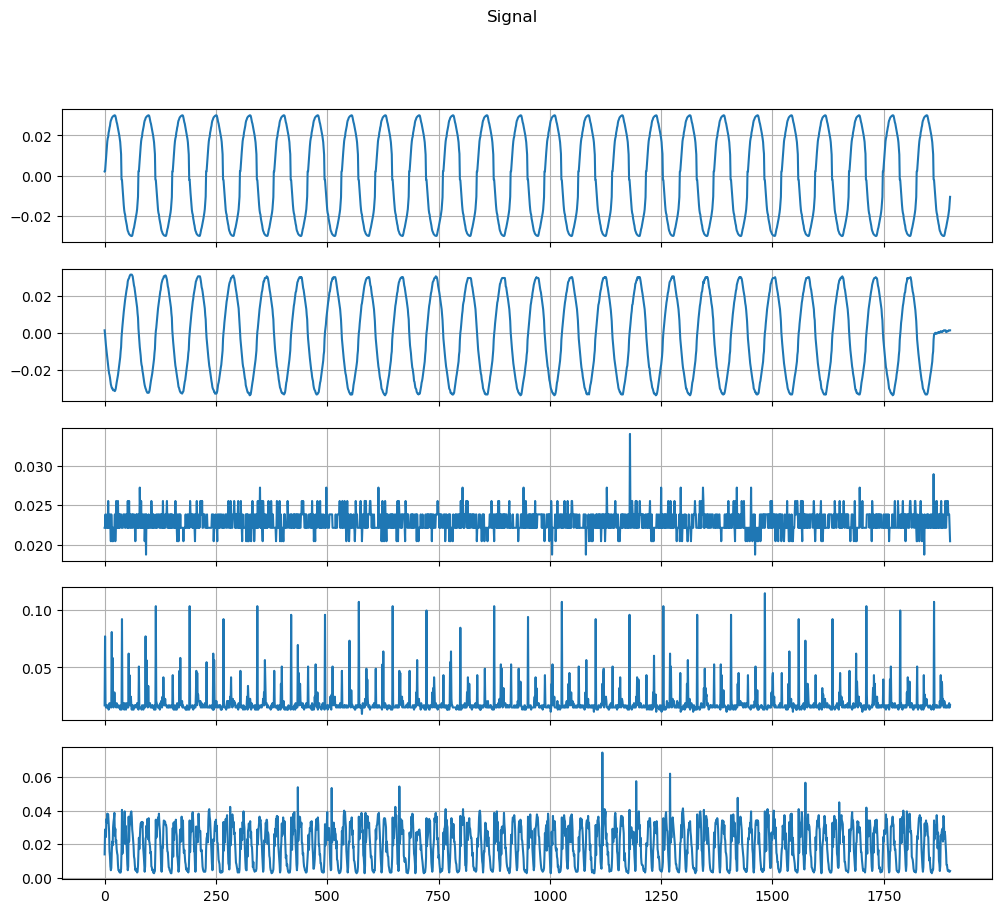

In [192]:
affichage_data(data_echantillon, seq_len, nb_channels=nb_channels)

# PCA

In [ ]:
# Reshape le tableau en (1191, 5 * 1900)
reshaped_data = data_echantillon.reshape(data_echantillon.shape[0], -1)

# Initialiser le PCA
n_components = 10  # Choisir 3 pour visualiser en 3D
pca = PCA(n_components=n_components)

# Appliquer le PCA
pca_result = pca.fit_transform(reshaped_data)

# Visualisation en 2D
plt.figure(figsize=(12, 6))

# Scatter plot en 2D (on utilise les deux premières composantes)
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("PCA - Projection 2D")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid()

ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.5)
ax.set_title("PCA - Projection 3D")
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_zlabel("Composante principale 3")

plt.tight_layout()
plt.show()

In [ ]:
# Pourcentage de variance expliquée par les composantes principales
explained_variance = pca.explained_variance_ratio_

# Afficher le pourcentage expliqué par les premières composantes
pourcentage_explique = explained_variance[:n_components] * 100
print(f"Pourcentage de variance expliquée par les {n_components} premières composantes : {pourcentage_explique}")
print(f"Total : {pourcentage_explique.sum()}%")


# Nettoyage des points isolé

In [ ]:
db = DBSCAN(eps=600, min_samples=10).fit(pca_result)

# Identifier les indices des points qui ne sont pas isolés
mask = db.labels_ != -1

# Filtrer les points
pca_result_filter = pca_result[mask]

# Visualisation en 2D
plt.figure(figsize=(12, 6))

# Scatter plot en 2D (on utilise les deux premières composantes)
plt.subplot(1, 2, 1)
plt.scatter(pca_result_filter[:, 0], pca_result_filter[:, 1], alpha=0.5)
plt.title("PCA - Projection 2D")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid()

ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(pca_result_filter[:, 0], pca_result_filter[:, 1], pca_result_filter[:, 2], alpha=0.5)
ax.set_title("PCA - Projection 3D")
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_zlabel("Composante principale 3")

plt.tight_layout()
plt.show()

# Cluster

In [ ]:
# Clustering avec KMeans
n_clusters = 6  # Choisir le nombre de clusters
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
clusters = kmeans.fit_predict(pca_result_filter)

# Compter le nombre de points dans chaque cluster
cluster_counts = Counter(clusters)

# Afficher le nombre de points par cluster
print("Nombre de points par cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} points")

# Visualisation en 3D avec les clusters
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

# Afficher les points avec des couleurs selon leur cluster
scatter = ax.scatter(pca_result_filter[:, 0], pca_result_filter[:, 1], pca_result_filter[:, 2], 
                     c=clusters, cmap='viridis', alpha=0.5)

# Ajouter une légende
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title("PCA avec Clustering KMeans - Projection 3D")
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_zlabel("Composante principale 3")

plt.show()

# Visualisation d'un signal par clusters

In [ ]:
for cluster in range(n_clusters):
    # Trouver un index d'un signal dans le cluster
    cluster_indices = np.where(clusters == cluster)[0]

    cluster_signals = data_echantillon[cluster_indices]

    print(f"Cluster n°{cluster}")

    for j in range(min(10, len(cluster_signals))):

        signal = cluster_signals[j]
        
         # Diviser le plot en 5 parties
        fig, axs = plt.subplots(signal.shape[0], 1, figsize=(12, 10), sharex=True)

        # Affichage du signal réel
        for i in range(signal.shape[0]):
            axs[i].plot(signal[i].reshape(signal.shape[2]), label=f'Signal réel {i+1}')
            axs[i].grid()
        
        plt.suptitle(f"Signal {j} du cluster {cluster}")
        plt.show()
